# Problem apprach

+ The sensor readings are distributed in a binary classification fashion (labeled as 1 and -1) indicates that it's a classification problem.
+ Find the most suitable model to rank those features with respect to their class labels.
+ Once the suitable model is determined, tweak the model parameters to get better accuracy.
+ As the last step, rank the features with respect to their class labels.

In [1]:
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
from numpy import mean, ndenumerate, std, where
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LogisticRegression,
    PassiveAggressiveClassifier,
    RidgeClassifier,
)
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (
    LeaveOneOut,
    RepeatedStratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

## Import and split dataset

In [2]:
def get_dataset(file, label_column):
    # Read dataset with making 1st row as a header and 1st column as an index.
    rawdata = pd.read_csv(file, header=0, index_col=0)

    # dataset with 2D shape of (n_samples, n_features)
    data = rawdata.drop(columns=[label_column], axis=1)
    labels = rawdata[label_column]  # calss labels

    # Summarize sensor data by class label.
    label_counter = Counter(labels)
    label_keys = [*label_counter.keys()]

    print(f"Description: {rawdata.describe()}")

    return data, labels, label_counter, label_keys

In [3]:
# get_dataset() input parameters
filepath = "D:/task_ML/task/task_data.csv"
label_column = "class_label"

data, labels, label_counter, label_keys = get_dataset(
    file=filepath, label_column=label_column
)

Description:        class_label     sensor0     sensor1     sensor2     sensor3  \
count   400.000000  400.000000  400.000000  400.000000  400.000000   
mean      0.000000    0.523661    0.509223    0.481238    0.509752   
std       1.001252    0.268194    0.276878    0.287584    0.297712   
min      -1.000000    0.007775    0.003865    0.004473    0.001466   
25%      -1.000000    0.299792    0.283004    0.235544    0.262697   
50%       0.000000    0.534906    0.507583    0.460241    0.510066   
75%       1.000000    0.751887    0.727843    0.734937    0.768975   
max       1.000000    0.999476    0.998680    0.992963    0.995119   

          sensor4     sensor5     sensor6     sensor7     sensor8     sensor9  
count  400.000000  400.000000  400.000000  400.000000  400.000000  400.000000  
mean     0.497875    0.501065    0.490480    0.482372    0.482822    0.541933  
std      0.288208    0.287634    0.289954    0.282714    0.296180    0.272490  
min      0.000250    0.000425    0.0

In [5]:
# display(label_counter)
# display(data)
# display(labels)

## Plot the dataset by class label

In [4]:
def scatter_plot(fig_size, nrows, ncols, label_counter):
    fig = plt.figure(figsize=fig_size)  # Create a figure environment

    # Scatter plot of each sensor (0 to 9) data distributed between class 1 and -1 for 400 samples.
    for nfeature in range(len(data.columns)):  # 10 sensors (feature size)
        ax = fig.add_subplot(nrows, ncols, nfeature + 1)  # Add a subplot on the go

        for label, datapoints in label_counter.items():
            sample_rows = where(labels == label)[0]  # select rows with a given label
            ax.scatter(
                sample_rows,
                data.iloc[sample_rows, nfeature],
                label="class: " + str(label),
            )
            ax.set_xlabel("Samples [n]")
            ax.set_ylabel("Reading")
            ax.set_title("Sensor " + str(nfeature))
            plt.legend(loc="upper right")

    return fig

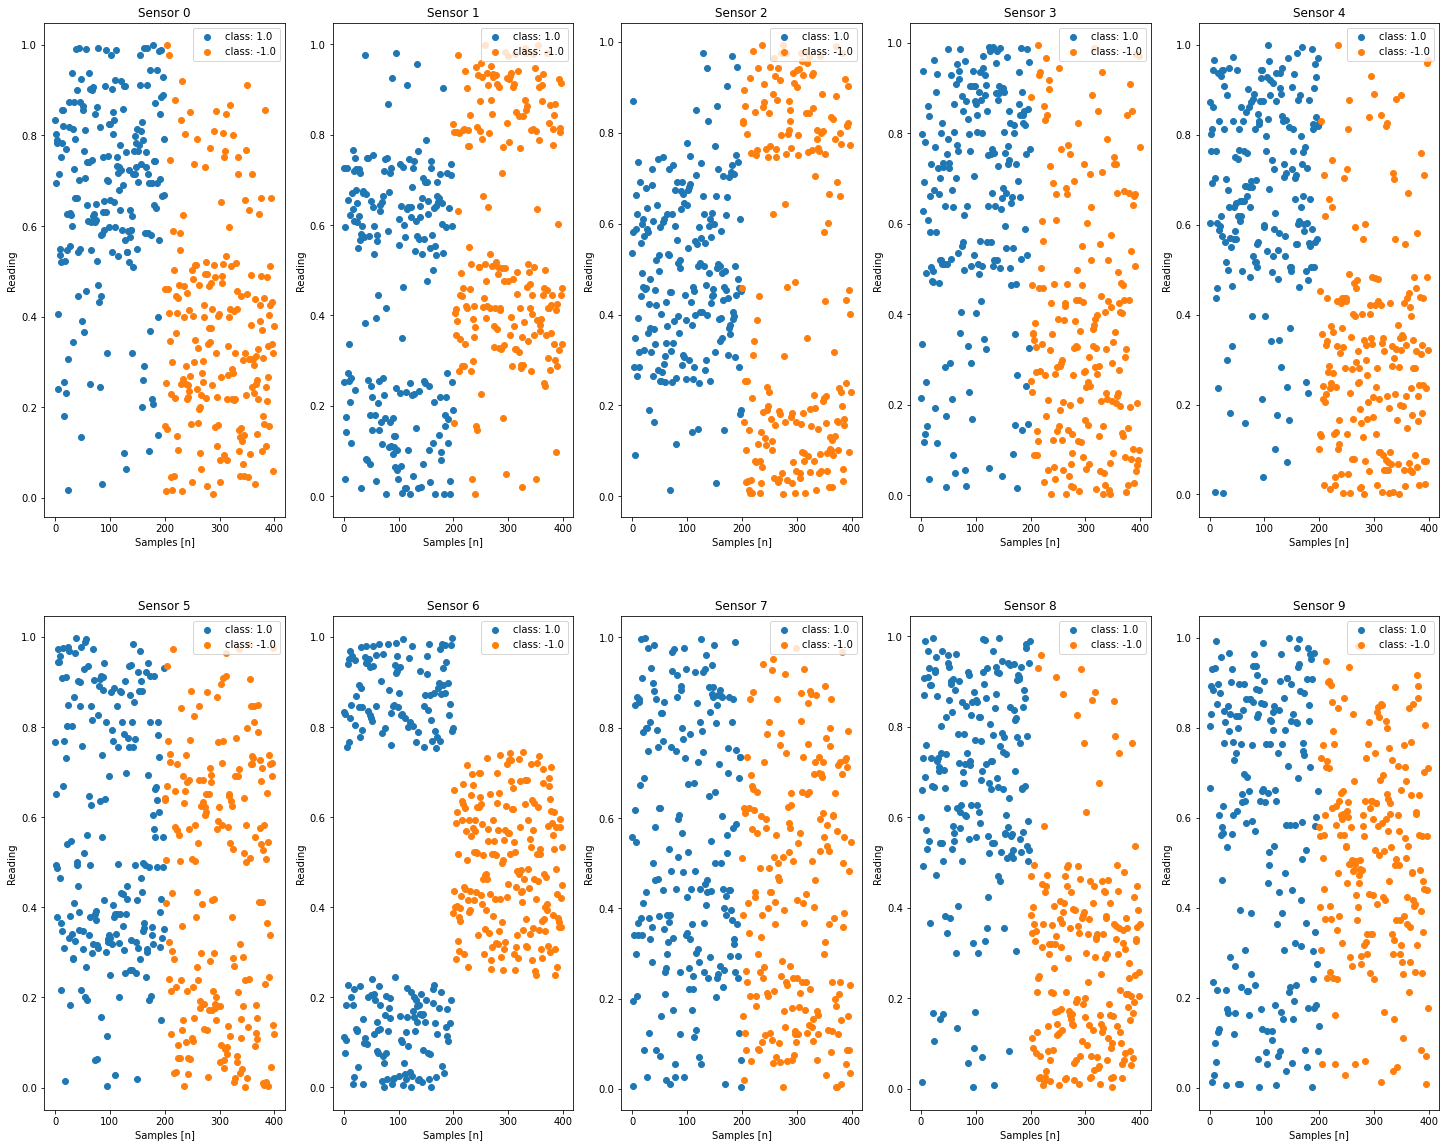

In [5]:
# scatter_plot() input parameters
fig_size = (25, 20)
nrows = 2
ncols = 5
label_counter = label_counter

sensor_plot = scatter_plot(fig_size, nrows, ncols, label_counter)

## Properties of artifically generated dataset

In [6]:
feature_corr = data.corr(method="pearson")

feature_corr.style.background_gradient(cmap="coolwarm").set_precision(2)

,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
sensor0,1.00,-0.22,0.02,0.25,0.30,0.16,-0.01,0.08,0.36,0.00
sensor1,-0.22,1.00,0.06,-0.11,-0.13,0.06,-0.11,0.03,-0.16,-0.02
sensor2,0.02,0.06,1.00,0.09,-0.02,-0.01,-0.06,0.01,-0.01,-0.06
sensor3,0.25,-0.11,0.09,1.00,0.30,0.04,-0.11,0.00,0.29,0.01
sensor4,0.30,-0.13,-0.02,0.30,1.00,0.18,-0.02,0.09,0.38,0.02
sensor5,0.16,0.06,-0.01,0.04,0.18,1.00,-0.06,0.02,0.22,0.07
sensor6,-0.01,-0.11,-0.06,-0.11,-0.02,-0.06,1.00,0.07,-0.07,0.04
sensor7,0.08,0.03,0.01,0.00,0.09,0.02,0.07,1.00,0.06,0.06
sensor8,0.36,-0.16,-0.01,0.29,0.38,0.22,-0.07,0.06,1.00,-0.03
sensor9,0.00,-0.02,-0.06,0.01,0.02,0.07,0.04,0.06,-0.03,1.00


Apperently there is no correlation found among the features.

# Evaluating different ML models
+ There are many models (i.e., __Random Forest, Logistic Regresssion, k-Nearest Neighbors, Decision Tree, Support Vector Machine, Naive Bayes, etc.__) available for deducing the feature importance.
+ Cross-validation is very helpful to validate our ML model regarding how well it would generalize new data. 
+ The goal of cross-validation is to define a data set to test the quality of the model in the training phase (i.e. validation dataset) in order to limit problems like overfitting and underfitting.
+ It is important to note that validation and training set should be drawn from the same distribution otherwise it would make things worse.

In [7]:
# Create a dict for model evaluation.
models_dict = {
    "LR": LogisticRegression(),
    "Pass/Aggr": PassiveAggressiveClassifier(),
    "Ridge": RidgeClassifier(),
    "KNeighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Extra Tree": ExtraTreeClassifier(),
    "SVM": SVC(),
    "Bayes": GaussianNB(),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "Random Forest": RandomForestClassifier(),
}

In [8]:
# Evaluate a model using cross-validation and returns a list of scores from ten repeats of stratifield 10-fold cross-validation.


def evaluate_model(model, data, labels):
    # Stratification applies different target distribution to different folds. Meaning the model is applied to the distribution according to the class labels instead of splitting the the distribution randomly like in train/test split and Kfold.
    cross_valid = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    scores = cross_val_score(
        model,
        data,
        labels,
        scoring="accuracy",
        cv=cross_valid,
        n_jobs=-1,
        error_score="raise",
    )

    return scores

In [9]:
results_list = []
names_list = []
mean_list = []
std_list = []

for name, model in models_dict.items():
    scores = evaluate_model(
        model, data, labels
    )  # 30 (10 splits * 3 repeatetion) values in score matrix
    results_list.append(scores)
    mean_list.append(mean(scores))  # mean of 30 score datapoints
    std_list.append(std(scores))  # std of 30 score datapoints
    names_list.append(name)

analysis_df = pd.DataFrame(
    data={"Model name": names_list, "Mean": mean_list, "Std. Deviation": std_list}
)
display(analysis_df)

,Model name,Mean,Std. Deviation
0,LR,0.92475,0.043373
1,Pass/Aggr,0.88650,0.062791
2,Ridge,0.92775,0.041967
3,KNeighbors,0.95275,0.032767
4,Decision Tree,0.96100,0.030480
5,Extra Tree,0.89625,0.060247
6,SVM,0.94475,0.036792
7,Bayes,0.95600,0.031843
8,LDA,0.92800,0.041725
9,QDA,0.94600,0.036352


In [10]:
display(analysis_df.sort_values(by=["Mean"], ascending=False))

,Model name,Mean,Std. Deviation
10,Random Forest,0.98750,0.018540
4,Decision Tree,0.96100,0.030480
7,Bayes,0.95600,0.031843
3,KNeighbors,0.95275,0.032767
9,QDA,0.94600,0.036352
6,SVM,0.94475,0.036792
8,LDA,0.92800,0.041725
2,Ridge,0.92775,0.041967
0,LR,0.92475,0.043373
5,Extra Tree,0.89625,0.060247


Boxplot is a standard way of displaying the distributated data.



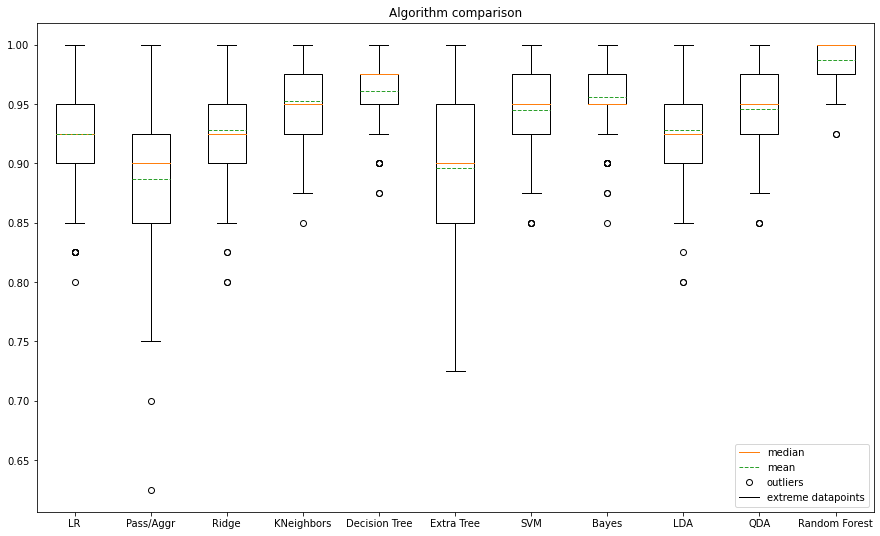

In [11]:
print("Boxplot is a standard way of displaying the distributated data.\n")

plt.figure(figsize=(15, 9))
bp = plt.boxplot(x=results_list, labels=names_list, showmeans=True, meanline=True)
plt.legend(
    [bp["medians"][0], bp["means"][0], bp["fliers"][0], bp["whiskers"][0]],
    ["median", "mean", "outliers", "extreme datapoints"],
)

plt.title("Algorithm comparison")
plt.show()

+ The Random Forest Classifier (RFC) has highest mean score and minimun std. deviation making it relatively more suitable to rank the sensors.
    + The RFC is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset.
    + This sub-samples (a.k.a bootstrap) are fed to decision trees with large gepth randomly.
    + The final result is basically the counting of majority of votes from all decision trees.
    
+ Pros:
    + Better scalability than decision tree
    + Improved bias

## 'k-fold' parameter evaluation 

In [12]:
# Finalize the model
rfc_model = RandomForestClassifier()

### Ideal cross-validation score

In [13]:
ideal_score = cross_val_score(
    rfc_model,
    data,
    labels,
    scoring="accuracy",
    cv=LeaveOneOut(),
    n_jobs=-1,
    error_score="raise",
)

In [14]:
print(f"Random Forest Classifier Ideal score: {mean(ideal_score)}")
print("The RCF model is quite efficient in predicting the validation set.")

Random Forest Classifier Ideal score: 0.9925
The RCF model is quite efficient in predicting the validation set.


+ __Startification__
    + Stratification is the process of rearranging the data in each fold to represent each class in an equal fashion.
    + For e.g., in binary classification each class comprises of 50% of the data. Therefore, it is best to arrange the data in every fold comprising around 50% of the instances from both the classes.


+ __Repeated Stratification k-fold__ 
    + Repeated stratification k-fold cross-validation replicates the procedure multiple times.
    + For e.g., if 10-fold cross-validation was repeated firve time, 50 different sets would be used ti estimate the model efficiency.

In [15]:
def evaluate_kfold(kfold_range, n_repeats, model):
    meanscore_list = []
    maxscore_list = []
    minscore_list = []

    for k in kfold_range:
        cross_valid = RepeatedStratifiedKFold(
            n_splits=k, n_repeats=n_repeats, random_state=1
        )
        scores = cross_val_score(
            model,
            data,
            labels,
            scoring="accuracy",
            cv=cross_valid,
            n_jobs=-1,
            error_score="raise",
        )
        meanscore_list.append(mean(scores))
        maxscore_list.append(scores.max() - mean(scores))
        minscore_list.append(mean(scores) - scores.min())

    return meanscore_list, maxscore_list, minscore_list

In [16]:
# input parameters
folds_range = range(2, 31)
n_repeatation = 5

# Run the RFC model
means_list, maxs_list, mins_list = evaluate_kfold(
    kfold_range=folds_range, n_repeats=n_repeatation, model=rfc_model
)

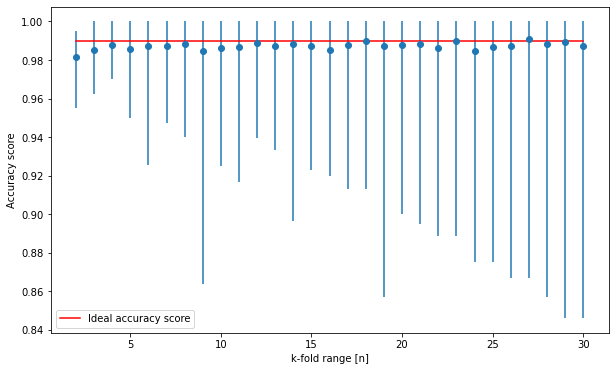

In [22]:
# Plot the results
figure = plt.figure(figsize=(10, 6))

plt.errorbar(folds_range, means_list, yerr=[mins_list, maxs_list], fmt="o")
plt.plot(
    folds_range,
    [mean(ideal_score) for _ in folds_range],
    color="r",
    label="Ideal accuracy score",
)

plt.xlabel("k-fold range [n]")
plt.ylabel("Accuracy score")
plt.legend(loc="lower left")

plt.show()

+ From above graph, it can be infered that for k=19 the estimate might be more accurate due to..
    1) No under/over fitting of the data
    2) Relatively low min/max error. 

# Feature importance

+ Feature importance is a technique to evaluate input features by assigning a score based on how important/predictable they could be!
+ Random Forest Tree model is used to assign the feature importance score since it has generated the highest accuracy for our binary dataset.  

## Random Forest classifier model prediction

<AxesSubplot:title={'center':'Random Forest Classifier (Accuracy = 98.48484848484848 %)'}, ylabel='Feature importance score'>

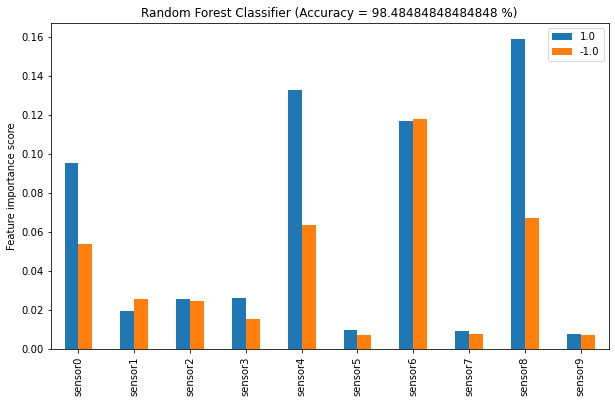

In [17]:
# Split test and train dataset
data_train, data_test, labels_train, labels_test = train_test_split(
    data, labels, test_size=0.33, random_state=1, stratify=labels, shuffle=True
)

rfc_model = RandomForestClassifier()
rfc_model.fit(data_train, labels_train)

# Evaluate the model
labels_predict = rfc_model.predict(data_test)

# Evaluate the predictions
accuracy = accuracy_score(labels_test, labels_predict)

importance = rfc_model.feature_importances_

class_feature_imp = {}
for label in set(labels):
    class_feature_imp[label] = dict(
        zip(range(data.shape[1]), mean(data[labels == label], axis=0) * importance)
    )

class_feature_imp_df = pd.DataFrame.from_dict(class_feature_imp)

class_feature_imp_df.index = data.columns

class_feature_imp_df.to_csv(path_or_buf="D:/task_ML/task/sensor_ranking.csv")

class_feature_imp_df.plot.bar(
    ylabel="Feature importance score",
    title=f"Random Forest Classifier (Accuracy = {accuracy*100} %)",
    figsize=(10, 6),
)

,1.0,-1.0
sensor9,0.008070,0.007336
sensor7,0.009595,0.007806
sensor5,0.009768,0.007543
sensor1,0.019344,0.025478
sensor2,0.025766,0.024600
sensor3,0.026024,0.015517
sensor0,0.095136,0.053758
sensor6,0.116927,0.117955
sensor4,0.132874,0.063787
sensor8,0.158899,0.067334


<AxesSubplot:title={'center':'Random Forest Classifier (Accuracy = 98.48484848484848 %)'}, xlabel='Sensor [n]', ylabel='Feature importance score'>

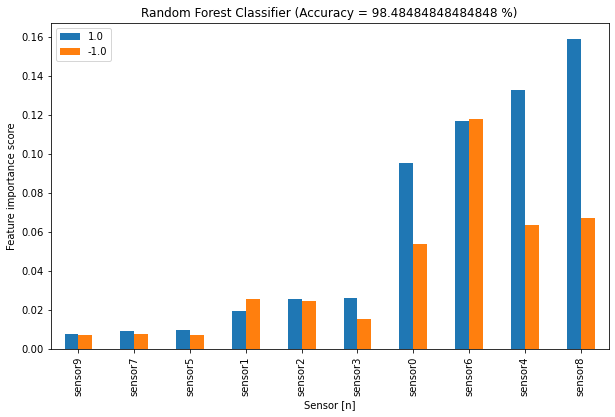

In [18]:
sensor_ranking0_df = class_feature_imp_df.sort_values(by=[1.0])
display(sensor_ranking0_df)

sensor_ranking0_df.plot.bar(
    xlabel="Sensor [n]",
    ylabel="Feature importance score",
    title=f"Random Forest Classifier (Accuracy = {accuracy*100} %)",
    figsize=(10, 6),
)

,1.0,-1.0
sensor9,0.008070,0.007336
sensor5,0.009768,0.007543
sensor7,0.009595,0.007806
sensor3,0.026024,0.015517
sensor2,0.025766,0.024600
sensor1,0.019344,0.025478
sensor0,0.095136,0.053758
sensor4,0.132874,0.063787
sensor8,0.158899,0.067334
sensor6,0.116927,0.117955


<AxesSubplot:title={'center':'Random Forest Classifier (Accuracy = 98.48484848484848 %)'}, xlabel='Sensor [n]', ylabel='Feature importance score'>

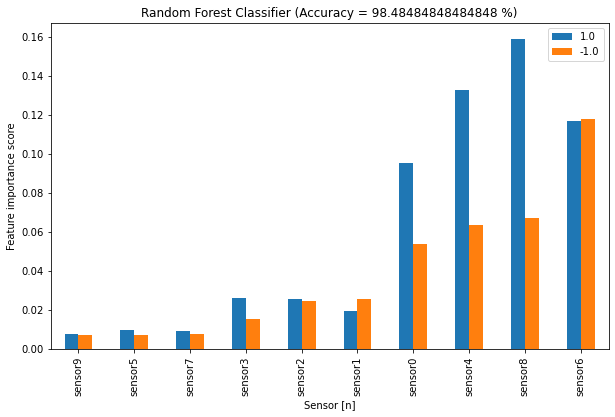

In [19]:
sensor_ranking1_df = class_feature_imp_df.sort_values(by=[-1.0])
display(sensor_ranking1_df)

sensor_ranking1_df.plot.bar(
    xlabel="Sensor [n]",
    ylabel="Feature importance score",
    title=f"Random Forest Classifier (Accuracy = {accuracy*100} %)",
    figsize=(10, 6),
)

+ The RFC model ranks the __sensor8, sensor6, and sensor4__ as the most important for __class 1__.
+ However, for __class -1__, the order is different (i.e., __sensor6, sensor8, sensor4__)
+ This pecularity takes place because of the __bias__ involved in this method.

In [20]:
ranking_class0 = sensor_ranking0_df[[1.0]]
ranking_class1 = sensor_ranking1_df[[-1.0]]

ranking_class0.to_csv(path_or_buf="D:/Projects/Sensor Classification/sensor_ranking_class1.csv")
ranking_class1.to_csv(path_or_buf="D:/Projects/Sensor Classification/sensor_ranking_class-1.csv")